# Sequence Models

Using data from yahoo finance, create a RNN, LSTM, and GRU to give predicitons of closing prices for Nividia stock.

Compare each model with each other to see which does better in making predictions. 

Build a multi-variable LSTM with the same Nividia stock data from yahoo finance and see how well it performs.

In [1]:
import yfinance as yf

nvidia_data = yf.Ticker("NVDA")

In [2]:
nvidia_price_df = nvidia_data.history(period='max')[['Close']]

In [3]:
nvidia_price_df

,Close
Date,
1999-01-22 00:00:00-05:00,0.037605
1999-01-25 00:00:00-05:00,0.041545
1999-01-26 00:00:00-05:00,0.038321
1999-01-27 00:00:00-05:00,0.038202
1999-01-28 00:00:00-05:00,0.038082
...,...
2025-12-01 00:00:00-05:00,179.909988
2025-12-02 00:00:00-05:00,181.449905
2025-12-03 00:00:00-05:00,179.580002


In [4]:
import pandas as pd
nvidia_price_df.to_csv('data/nvidia_stock_price_max_hist.csv')

In [5]:
nvidia_price_df.describe()

,Close
count,6761.000000
mean,13.141670
std,34.654923
min,0.031278
25%,0.262215
50%,0.447219
75%,5.475042
max,207.028473


In [6]:
nvidia_close = nvidia_price_df[['Close']]

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

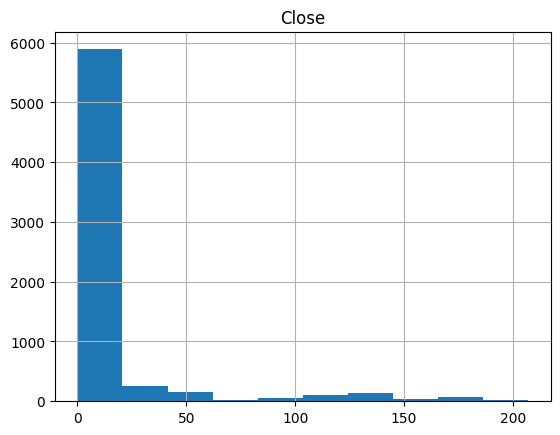

In [7]:
import matplotlib.pyplot as plt
nvidia_close.hist()

<Axes: xlabel='Date'>

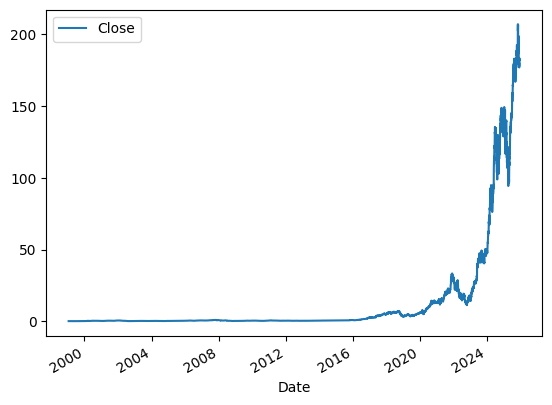

In [8]:
nvidia_close.plot()

In [9]:
nvidia_close_norm = (nvidia_close - nvidia_close.min()) / (nvidia_close.max() - nvidia_close.min())

<Axes: xlabel='Date'>

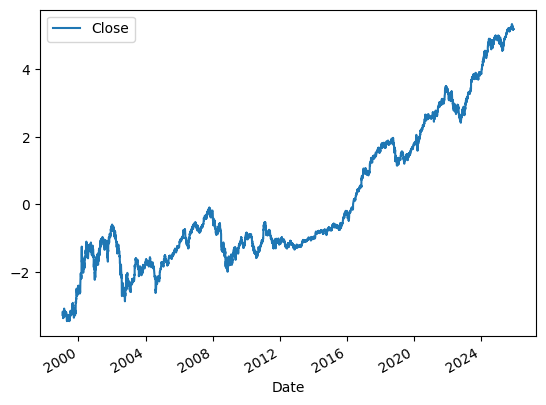

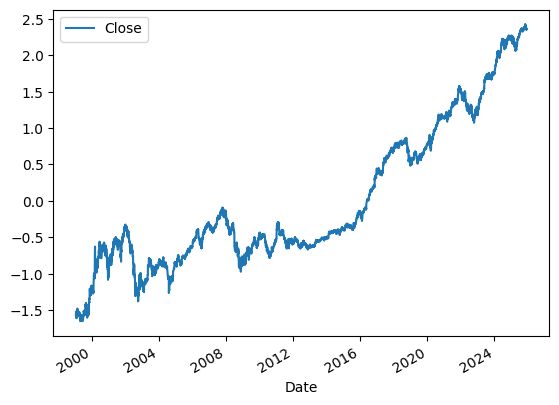

In [10]:
import numpy as np
nv_log = np.log(nvidia_close)
nv_log.plot()
nv = (nv_log - nv_log.mean()) / nv_log.std()
nv.plot()

In [1]:
from data_handler import (
    extract_stock_close_price,
    log_transformation,
    standardization,
    split_train_test_set,
    sliding_window,
    split_feature_targets,
    split_train_val_data,
)

file = 'data/nvidia_stock_price_max_hist.csv'
close_raw = extract_stock_close_price("NVDA", "max", file, "Close")

test_ratio = 0.20
train_raw, test_raw = split_train_test_set(close_raw, test_ratio)

train_log = log_transformation(train_raw)
train_clean, train_log_mean, train_log_std = standardization(train_log)

test_log = log_transformation(test_raw)
test_clean = (test_log - train_log_mean) / train_log_std


In [ ]:
window_size = 50
window_step = 2
val_ratio = 0.20

### CAUSE OF ERROR ####
# Seems to be data leakage here: Sliding window will have shared values.
# [x1, x2, x3] -> [x4], [x2, x3, x4] -> [x5]
# Therefore, when I split, train set and val set are sharing values.
# Val set is never a separate data set. AKA, data leakage occuring.
# DOUBLE CHEKC IF THIS TRUE, GOT IT FROM CHATGPT
# Would need to be:
# Train - [x1, x2, x3][x4] | Val - [x5,x6][x7]
training_data_windows = sliding_window(train_clean, window_size, window_step)
train_set, val_set = split_train_val_data(training_data_windows, val_ratio)
######################

X_train, y_train = split_feature_targets(train_set)
X_val, y_val = split_feature_targets(val_set)

In [3]:
test_set = sliding_window(test_clean, window_size, window_step)
X_test, y_test = split_feature_targets(test_set)

In [4]:
from sequence_model import SimpleRNN, train_model
rnn = SimpleRNN()
num_epochs=10
batch_size=32
learning_rate=0.001
train_loss, val_loss = train_model(rnn, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val)

Epoch 1
Train loss: 0.9126208610409993
Val Loss: 0.7803343721621093
Epoch 2
Train loss: 0.6578018591209824
Val Loss: 0.5540852560439989
Epoch 3
Train loss: 0.3720830230229781
Val Loss: 0.2429230741441383
Epoch 4
Train loss: 0.11446324972591053
Val Loss: 0.08239373926508484
Epoch 5
Train loss: 0.07432754334487461
Val Loss: 0.054514922608047654
Epoch 6
Train loss: 0.051696967226321465
Val Loss: 0.03787145351071515
Epoch 7
Train loss: 0.03701323686120651
Val Loss: 0.027266637742286548
Epoch 8
Train loss: 0.02756827359397513
Val Loss: 0.02035587342245327
Epoch 9
Train loss: 0.02110210626467181
Val Loss: 0.015646827187516636
Epoch 10
Train loss: 0.016453617879960802
Val Loss: 0.012313894669898132


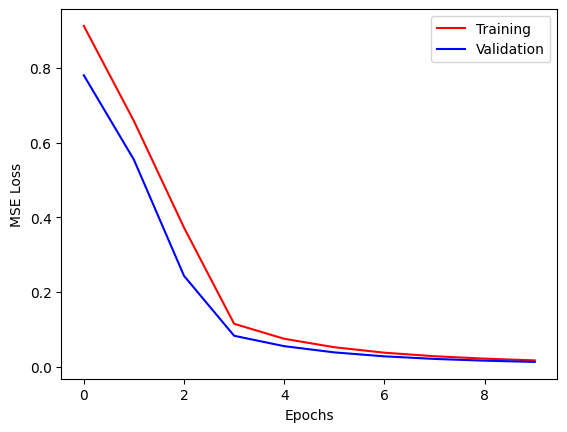

In [5]:
import matplotlib.pyplot as plt
epochs = [*range(num_epochs)]
plt.plot(epochs, train_loss, label="Training", color="red")
plt.plot(epochs, val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [18]:
import torch
from torch.nn import functional as F
import numpy as np

@torch.no_grad()
def test_model(model, X_test, y_test):
    model.eval()
    all_pred = []
    test_losses = []

    X_test = torch.from_numpy(X_test.astype(np.float32)).to(device="mps")
    y_test = torch.from_numpy(y_test.astype(np.float32)).to(device="mps")
    
    for i in range(len(X_test)):
        y_pred = model(X_test[i])
        loss = F.mse_loss(y_pred, y_test[i])

        all_pred.append(y_pred.item())
        test_losses.append(loss)
    
    return all_pred, test_losses

In [19]:
#from sequence_model import test_model

all_pred, test_losses = test_model(rnn, X_test, y_test)

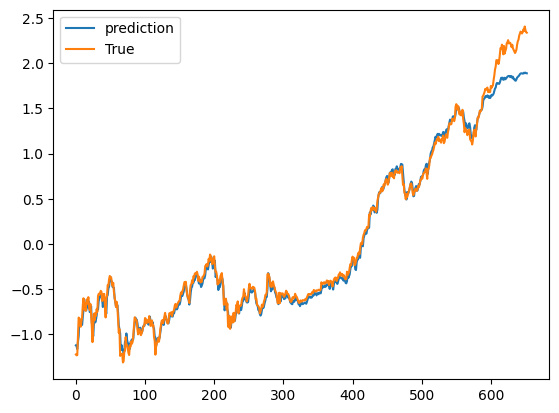

In [23]:
plt.plot(all_pred, label="prediction")
plt.plot(y_test, label="True")
plt.legend()

In [16]:
def generate_x_y_batches(features, targets, batch_size):
    data_size = len(features)
    if data_size != len(targets):
        raise ValueError("feature and targets not same length.")
    
    X_batches = generate_batches(features, data_size, batch_size)
    y_batches = generate_batches(targets, data_size, batch_size)

    return X_batches, y_batches

In [87]:
@torch.no_grad()
def evaluate_model(model, num_epochs, batch_size, features, targets):

    X_batches, y_batches = generate_x_y_batches(features, targets, batch_size)
    num_batches = len(X_batches)

    losses = []
    all_pred = []
    actual_targets = []

    model.eval()
    total_loss = 0
    for batch in range(num_batches):
        X_test = torch.from_numpy(X_batches[batch].astype(np.float32)).to(device="mps")
        y_test = torch.from_numpy(y_batches[batch].astype(np.float32)).to(device="mps")
        
        y_pred = model(X_test)
        loss = F.mse_loss(y_pred, y_test)
        total_loss += loss.item()
        
        all_pred.append(y_pred.cpu().numpy())
        actual_targets.append(y_test.cpu().numpy())
                
        average_eval_loss = total_loss/num_batches
        losses.append(average_eval_loss)
        
        print(f"Eval Loss: {average_eval_loss}")
    
    return all_pred, actual_targets, losses

In [ ]:
from sequence_model import test_model
all_pred, test_losses = test_model(rnn, X_test, y_test)

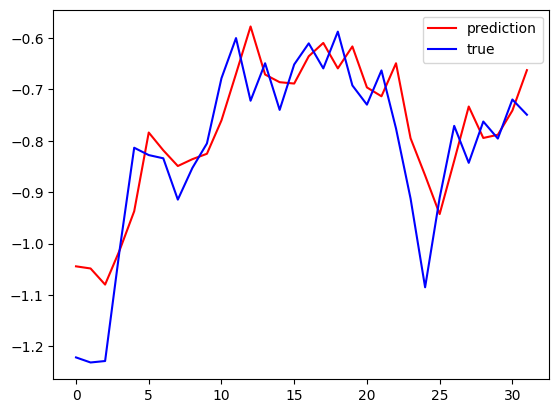

In [99]:
plt.plot(all_pred[0], label="prediction", color="red")
plt.plot(y_test[0:32], label="true", color="blue")
plt.legend()

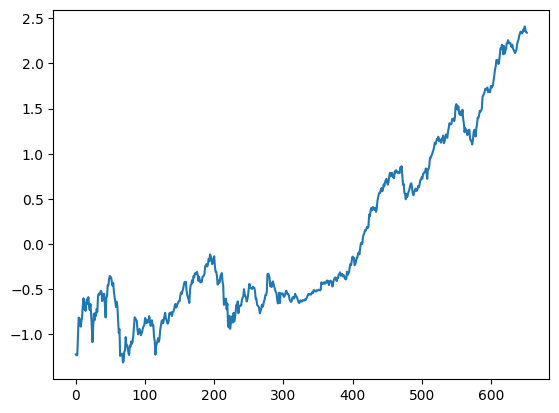

In [94]:
plt.plot(y_test)

In [ ]:
all_pred

[array([[-1.1305803 ],
        [-1.1278936 ],
        [-1.1592406 ],
        [-1.0979445 ],
        [-1.0296949 ],
        [-0.8863401 ],
        [-0.8972121 ],
        [-0.93268055],
        [-0.92602885],
        [-0.9162751 ],
        [-0.8523785 ],
        [-0.76698726],
        [-0.66620606],
        [-0.72428364],
        [-0.76741123],
        [-0.7727794 ],
        [-0.7266626 ],
        [-0.6889942 ],
        [-0.7245906 ],
        [-0.70536375],
        [-0.7644114 ],
        [-0.79164386],
        [-0.74597555],
        [-0.85574937],
        [-0.94269854],
        [-1.0245148 ],
        [-0.9412969 ],
        [-0.8312177 ],
        [-0.8627131 ],
        [-0.8789649 ],
        [-0.8351097 ],
        [-0.7553949 ]], dtype=float32),
 array([[-0.7390763 ],
        [-0.69177085],
        [-0.6528549 ],
        [-0.6210309 ],
        [-0.6012799 ],
        [-0.6034991 ],
        [-0.64779675],
        [-0.72596616],
        [-0.67901176],
        [-0.6335103 ],
        [-0.64542

In [29]:
y_test

array([[-1.22175727e+00],
       [-1.23161677e+00],
       [-1.22877738e+00],
       [-1.01238776e+00],
       [-8.13490744e-01],
       [-8.27764173e-01],
       [-8.34049800e-01],
       [-9.14499471e-01],
       [-8.52811247e-01],
       [-8.05135110e-01],
       [-6.78112034e-01],
       [-5.99951299e-01],
       [-7.21915526e-01],
       [-6.48979261e-01],
       [-7.39759434e-01],
       [-6.51307741e-01],
       [-6.10240214e-01],
       [-6.58985882e-01],
       [-5.87402405e-01],
       [-6.92145427e-01],
       [-7.29547666e-01],
       [-6.62925223e-01],
       [-7.76053444e-01],
       [-9.12353323e-01],
       [-1.08518696e+00],
       [-9.10927077e-01],
       [-7.70897441e-01],
       [-8.42873780e-01],
       [-7.62431299e-01],
       [-7.95604963e-01],
       [-7.19556288e-01],
       [-7.49196851e-01],
       [-5.75392394e-01],
       [-5.50174010e-01],
       [-5.58605593e-01],
       [-5.41125778e-01],
       [-5.17662736e-01],
       [-5.28996395e-01],
       [-6.3

In [70]:
print(len(all_pred))

210


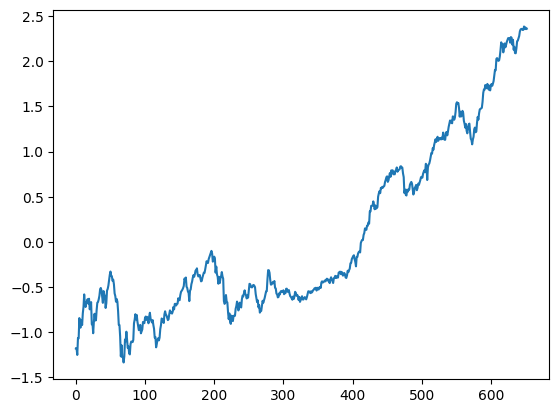

In [55]:
plt.plot(X_test[:,-1,:])

In [60]:
a = len(all_pred[0])
b = len(all_pred)
c = a*b
print(a)
print(b)
print(c)

32
210
6720


AttributeError: 'list' object has no attribute 'shape'

In [49]:
y_test.shape

(653, 1)

In [50]:
X_test.shape

(653, 49, 1)